<a href="https://colab.research.google.com/github/Kobai/name-that-genre/blob/master/lyric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import string
import re
from os import listdir
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Input, Dropout, concatenate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from collections import Counter
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
from zipfile import ZipFile
with ZipFile('lyrics.zip', 'r') as zipObj:
  zipObj.extractall()

In [0]:
import pandas as pd
df = pd.read_csv('lyrics.csv')

In [0]:
df.head()

In [0]:
df = df.drop(columns=['index', 'song', 'year', 'artist'])

In [0]:
df.to_csv('small_lyrics.csv', index=False)

In [0]:
df['lyrics'].head()[0]

In [0]:
def clean_lyrics(doc):
  stemmer = PorterStemmer()
  doc.replace('\n', ' ')
  tokens = doc.split()
  re_punc = re.compile(f'[{re.escape(string.punctuation)}]')
  tokens = [re_punc.sub('',w) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  tokens = [word for word in tokens if len(word) >1]
  tokens = [word.lower() for word in tokens]
  tokens = [stemmer.stem(word) for word in tokens]
  return ' '.join(tokens)

def is_english(doc):
  tokens = doc.split()
  counter = 0
  threshold = int(len(tokens) * 0.3)
  for token in tokens:
    if not wordnet.synsets(token):
      counter +=1
    if counter >= threshold:
      return False
  return True

In [0]:
clean_lyrics(df['lyrics'].head()[0])

In [0]:
df['lyrics'] = df['lyrics'].astype(str).apply(lambda x: clean_lyrics(x))

In [0]:
df = df[df['lyrics'] != 'nan' ]

In [0]:
df = df[df.apply(lambda x: is_english(x['lyrics']), axis=1)]

In [0]:
df.to_csv('clean_lyrics.csv', index=False)

In [0]:
df['lyrics'].to_csv('output.txt', index=False)

In [0]:
def open_txt(filename):
  with open(filename, 'r') as file:
    return file.read()

In [0]:
raw_text = open_txt('output.txt')
lines = raw_text.split('\n')
print(lines[1])

In [0]:
df = pd.read_csv('clean_lyrics.csv')
df['strlen'] = df['lyrics'].str.len()
df = df[df['strlen'] >= 50]
df = df[df['strlen'] <= 2500]
df['strlen'].describe()

In [0]:
lines = df['lyrics'].tolist()

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)

In [0]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size: {vocab_size}')
max_length = max([len(s.split()) for s in lines])
print(f'Max Length: {max_length}')

In [0]:
def encode_docs(vocab_size, max_length, docs):
  encoded = tokenizer.texts_to_sequences(docs)
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [0]:
def define_model(vocab_size, max_length):
  inputs1 = Input(shape=(max_length,))
  embedding1 = Embedding(vocab_size, 100)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(max_length,))
  embedding2 = Embedding(vocab_size, 100)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(max_length,))
  embedding3 = Embedding(vocab_size, 100)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  merged = concatenate([flat1, flat2, flat3])
  dense1 = Dense(64, activation='relu')(merged)
  dense2 = Dense(32, activation='relu')(dense1)
  outputs = Dense(12, activation='softmax')(dense2)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  plot_model(model, to_file='model.png', show_shapes=True)
  return model

In [0]:
def test_model(model):
  preds = model.predict([Xtest, Xtest, Xtest])
  preds = [np.argmax(pred) for pred in preds]
  labels = [np.argmax(label) for label in ytest]
  print(classification_report(labels, preds))
  cm = confusion_matrix(labels, preds)
  fig, ax = plt.subplots(figsize=(16,16)) 
  sn.set(font_scale=1.4)
  sn.heatmap(cm, annot=True, annot_kws={'size': 12}) 

In [113]:
X = encode_docs(tokenizer, max_length, lines)
genre_dict = dict(zip(df['genre'].unique().tolist(), range(12)))
print(genre_dict)
y = df['genre'].astype(str).apply(lambda x: genre_dict[x]).tolist()
y = to_categorical(y, num_classes=12)

{'Pop': 0, 'Hip-Hop': 1, 'Not Available': 2, 'Rock': 3, 'Metal': 4, 'Other': 5, 'Country': 6, 'Jazz': 7, 'Electronic': 8, 'Folk': 9, 'Indie': 10, 'R&B': 11}
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
from sklearn.model_selection import train_test_split
(Xtrain, Xtest, ytrain, ytest) = train_test_split(X,y,test_size=0.2, random_state=42)

In [115]:
model = define_model(vocab_size, max_length)
model.fit([Xtrain, Xtrain, Xtrain], ytrain, epochs=7, batch_size=128)
model.save('model.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 2377)]       0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 2377)]       0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 2377)]       0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 2377, 100)    10506800    input_17[0][0]                   
____________________________________________________________________________________________

              precision    recall  f1-score   support

           0       0.39      0.35      0.37      4181
           1       0.77      0.70      0.73      2083
           2       0.20      0.13      0.16      2102
           3       0.60      0.75      0.66     13591
           4       0.57      0.59      0.58      3026
           5       0.27      0.03      0.06       512
           6       0.49      0.36      0.42      1952
           7       0.39      0.37      0.38       934
           8       0.20      0.14      0.17       843
           9       0.33      0.05      0.09       278
          10       0.18      0.04      0.07       444
          11       0.31      0.11      0.16       403

    accuracy                           0.54     30349
   macro avg       0.39      0.30      0.32     30349
weighted avg       0.51      0.54      0.51     30349



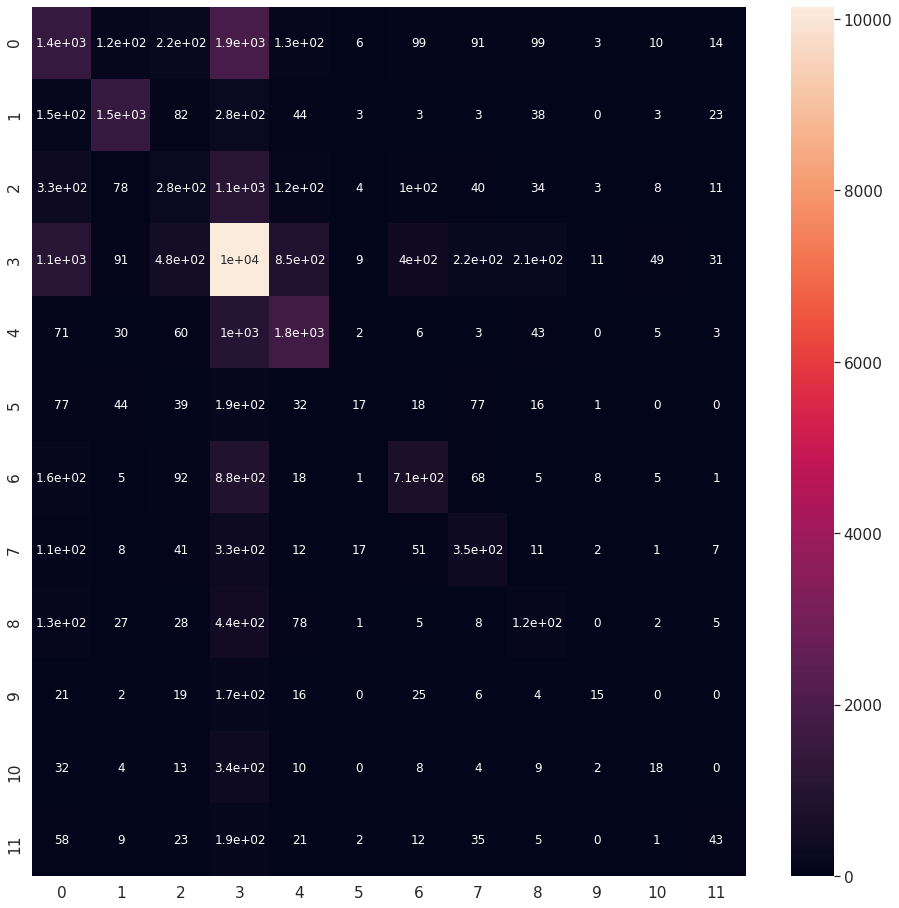

In [159]:
test_model(model)